# Lab 05 - Facial emotion recognition

## Import libraries

In [1]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.feature import local_binary_pattern

## Get and prepare Data

In [2]:
face_cascade = cv2.CascadeClassifier('../Data/haarcascade_frontalface_default.xml')

In [3]:
def load_and_detect_faces(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Detect face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w] # Crop to face region
                        images.append(face_region)
                        labels.append(label)
    return images, labels


In [4]:
# Set paths for training and testing folders
train_folder_path = "../Data/CK_dataset/train"
test_folder_path = "../Data/CK_dataset/test"

# Load and detect faces in training and testing data
x_train, y_train = load_and_detect_faces(train_folder_path)
x_test, y_test = load_and_detect_faces(test_folder_path)

The following snippet performs histogram equalization on a list of images to enhance contrast and potentially improve feature extraction quality. Using histogram equalization helps the subsequent feature extraction method (like LBP or ORB) by increasing image contrast, which can make facial features more distinguishable and improve classifier performance. This is useful in cases where lighting conditions in the images vary significantly. Similarly, StandardScaler and make_pipeline are part of scikit-learn and are useful for creating a pipeline where data preprocessing and model training can be done sequentially.

In [7]:
# Preprocess the images with histogram equalization
def preprocess_images(images):
    preprocessed_images = []
    for img in images:
        # Apply histogram equalization to improve contrast
        img = cv2.equalizeHist(img)
        preprocessed_images.append(img)
    return preprocessed_images

This following snippet will get feature vectors using Local Binary Patterns (LBP). Each face is resized to 64x64 pixels and processed to extract texture patterns, forming a histogram that represents the face’s unique textures. This histogram is normalized to ensure consistency across varying lighting conditions. The resulting array of histograms provides a compact and effective representation of facial textures, ideal for training a classifier to recognize different expressions.


In [11]:
# Define parameters for LBP
radius = 1
n_points = 8 * radius

# Function to extract LBP features from the cropped face images
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        # Resize face image to a standard size if needed
        img = cv2.resize(img, (64, 64)) # Standard size
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        # Histogram of LBP patterns
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        # Normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.append(hist)
    return np.array(lbp_features)

In [12]:
# Extract LBP features from training and testing face regions
x_train_features = extract_lbp_features(x_train)
x_test_features = extract_lbp_features(x_test)

## Train and test model

Now, this snippet is to set up and train an SVM classifier for recognizing facial emotion from feature vectors extracted from images. By utilizing a pipeline that includes feature scaling, the code ensures that the model receives well-prepared input data, which enhances its performance and accuracy in predicting facial expressions based on the trained features. SVC: Initializes the SVM classifier with a radial basis function (RBF) kernel, which is effective for nonlinear decision boundaries. The C parameter controls the trade-off between achieving a low training error and a low testing error, while gamma='scale' automatically determines the gamma value based on the number of features.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create an SVM pipeline with scaling and RBF kernel
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=7, gamma='scale'))

# Train and evaluate the model
svm_classifier.fit(x_train_features, y_train)

# Train the classifier on the training features
svm_classifier.fit(x_train_features, y_train)

,steps,"[('standardscaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,7
,kernel,'rbf'
,degree,3
,gamma,'scale'


## Predict and show results

In [16]:
# Predict the test set results
y_pred = svm_classifier.predict(x_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(len(y_test))
print(conf_matrix)

Accuracy: 39.16%
143
[[ 5  0  7  5  1  0]
 [ 1  0  0  4  2  0]
 [ 2  0 13  7  0  8]
 [ 3  0  3 18  1 11]
 [ 1  0  4  4  5  3]
 [ 2  0  6 11  1 15]]


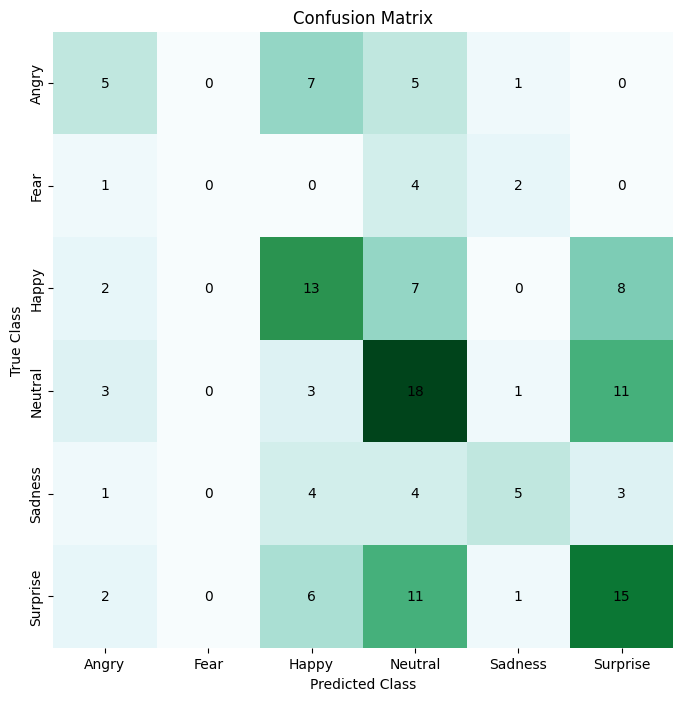

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming class names are defined
class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix with class names
plt.figure(figsize=(8,8))
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)

# Add annotations with both counts and percentages
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}", ha="center", va="center", color="black", fontsize=10)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

## Single Image Test

In [18]:
# Define parameters for LBP
radius = 1
n_points = 8 * radius

# Function to preprocess and extract LBP features from a face image
def preprocess_and_extract_features(face_img):
    # Resize the face image to stndard size:
    face_img = cv2.resize(face_img, (64, 64))

    # Apply LBP
    lbp = local_binary_pattern(face_img, n_points, radius, method='uniform')

    # Compute the histogram of LBP patterns
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    return hist.reshape(1, -1) # Return as a 2D for model input

In [19]:
# Function to predict and display the expression of a single image
def predict_emotion(image_path, model):
    # Load the image in color
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or could not be loaded.")

    # Convert the image to grayscale for face detection
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # If no faces are detected, return
    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    # Loop over the detected faces
    for (x, y, w, h) in faces:
        face_region = gray_img[y:y+h, x:x+w] # Crop the detected face region

        # Extract features from the face region
        features = preprocess_and_extract_features(face_region)

        # Predict the expression (directly get the predicted label as a string
        predicted_expression = model.predict(features)[0]

        # Draw a rectangle around the face
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2) # Red rectangle

        # Display the predicted label above the rectangle
        cv2.putText(img, predicted_expression, (x, y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 2)

    # Convert to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with predictions
    plt.imshow(img_rgb)
    plt.title(f"Predicted Expression: {predicted_expression}")
    plt.axis("off")
    plt.show()

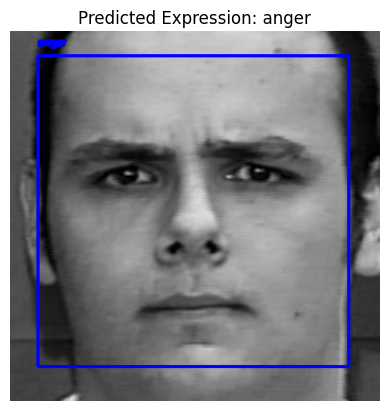

In [20]:
# Example path to an image
image_path = "../Data/CK_dataset/test/anger/8.jpg"
predict_emotion(image_path, svm_classifier)